# Transfer learning with the Neural Force Field

This Jupyter Notebook contains a demonstration on how to use the `nff` package to transfer learning between different methods. Most of it is similar to the first tutorial, and we'll go through the same steps when setting it up. The difference, however, is that we'll now train one model and later retrain its last layers to learn the new energies/forces.

In [1]:
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../..")


import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader

from nff.data import Dataset, split_train_validation_test, collate_dicts
from nff.train import Trainer, get_trainer, get_model, loss, hooks, metrics, evaluate
from nff.train.transfer import freeze_parameters, unfreeze_readout

In [2]:
DEVICE = 1
INDIR = './sandbox'
OUTDIR = './sandbox/transfer'
OUTDIR_2 = './sandbox/transfer2'
BATCH_SIZE = 100

if os.path.exists(OUTDIR):
    shutil.rmtree(OUTDIR)
    os.mkdir(OUTDIR)
    
if os.path.exists(OUTDIR_2):
    shutil.rmtree(OUTDIR_2)
    os.mkdir(OUTDIR_2)

## Loading the relevant data

The dataset we'll work with contains ~500 geometries of ethanol, each calculated with the DLPNO-CCSD(T) level of theory. The procedure to create the validation sets will be exactly the same.

In [3]:
dataset = Dataset.from_file('./data/dataset_dlpno.pth.tar')

In [4]:
dset_train = dataset.copy()
dset_train.props['energy'] = dset_train.props.pop('energy_gga')
dset_train.props['energy_grad'] = dset_train.props.pop('energy_gga_grad')

dset_transf = dataset.copy()
dset_transf.props['energy'] = dset_transf.props.pop('energy_dlpno')
dset_transf.props['energy_grad'] = dset_transf.props.pop('energy_dlpno_grad')

In [5]:
split_datasets = {
    'normal': split_train_validation_test(dset_train, val_size=0.2, test_size=0.2),
    'transf': split_train_validation_test(dset_transf, val_size=0.2, test_size=0.7)
}

split_loaders = {
    key: {
        'train': DataLoader(train, batch_size=BATCH_SIZE, collate_fn=collate_dicts),
        'val': DataLoader(val, batch_size=BATCH_SIZE, collate_fn=collate_dicts),
        'test': DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
    }
    for key, (train, val, test) in split_datasets.items()
}

## Loading the pretrained model and freezing its convolution layers

In [6]:
params = {
    'n_atom_basis': 256,
    'n_filters': 256,
    'n_gaussians': 32,
    'n_convolutions': 4,
    'cutoff': 5.0,
    'trainable_gauss': True
}

model = get_model(params)

The model will be trained on GGA energies and forces. To do so, we just have to create a loss function for these parameters:

In [7]:
loss_fn = loss.build_mse_loss(loss_coef={'energy': 0.01, 'energy_grad': 1})

We should also select an optimizer for our recently created model:

In [8]:
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=3e-4)

### Metrics and hooks

In [9]:
train_metrics = [
    metrics.MeanAbsoluteError('energy'),
    metrics.MeanAbsoluteError('energy_grad')
]

In [10]:
train_hooks = [
    hooks.MaxEpochHook(200),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | ',
        time_strf='%M:%S',
        log_memory=False
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

### Trainer wrapper

In [11]:
T = Trainer(
    model_path=OUTDIR,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=split_loaders['normal']['train'],
    validation_loader=split_loaders['normal']['val'],
    checkpoint_interval=1,
    hooks=train_hooks
)

Now we can finally train the model using the method `train` from the `Trainer`:

In [12]:
T.train(device=DEVICE, n_epochs=50)

 Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy | MAE_energy_grad | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 26.09it/s]


25:09 |     1 |     3.000e-04 |   257.3038 |         83.2837 |     2.6669 |          6.8861 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 27.99it/s]


25:10 |     2 |     3.000e-04 |    49.3272 |         28.1082 |     3.4146 |          3.8428 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 26.26it/s]


25:11 |     3 |     3.000e-04 |    20.0786 |         12.9640 |     0.6499 |          2.5759 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 27.22it/s]


25:12 |     4 |     3.000e-04 |    10.5321 |          7.6884 |     0.3469 |          1.9436 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 27.31it/s]


25:13 |     5 |     3.000e-04 |     6.7750 |          6.0951 |     1.2612 |          1.7983 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 27.89it/s]


25:14 |     6 |     3.000e-04 |     5.0597 |          5.1040 |     0.8638 |          1.6851 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 27.18it/s]


25:15 |     7 |     3.000e-04 |     4.2122 |          3.4772 |     0.2944 |          1.3180 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 29.37it/s]


25:16 |     8 |     3.000e-04 |     3.5962 |          3.2548 |     0.6769 |          1.2802 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 27.25it/s]


25:17 |     9 |     3.000e-04 |     3.2270 |          2.8883 |     0.9205 |          1.1974 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 25.42it/s]


25:18 |    10 |     3.000e-04 |     2.8752 |          2.6152 |     0.2471 |          1.1800 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 24.51it/s]


25:20 |    11 |     3.000e-04 |     2.6689 |          3.1630 |     0.2283 |          1.3758 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 26.80it/s]


25:21 |    12 |     3.000e-04 |     2.5829 |          2.2296 |     0.1797 |          1.0981 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 28.30it/s]


25:22 |    13 |     3.000e-04 |     2.3757 |          2.2902 |     0.5929 |          1.0506 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 28.24it/s]


25:23 |    14 |     3.000e-04 |     2.0706 |          1.7715 |     0.5560 |          0.9405 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 26.80it/s]


25:24 |    15 |     3.000e-04 |     2.0321 |          2.7863 |     0.2076 |          1.3130 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 26.96it/s]


25:25 |    16 |     3.000e-04 |     2.0853 |          1.7123 |     0.5419 |          0.9098 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 28.48it/s]


25:26 |    17 |     3.000e-04 |     1.6708 |          1.4059 |     0.7395 |          0.8160 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 26.83it/s]


25:27 |    18 |     3.000e-04 |     1.6588 |          1.5272 |     0.3843 |          0.9106 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 28.85it/s]


25:28 |    19 |     3.000e-04 |     1.6721 |          1.4017 |     0.7736 |          0.8374 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 27.32it/s]


25:29 |    20 |     3.000e-04 |     1.4892 |          1.2602 |     0.7396 |          0.7925 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 27.35it/s]


25:30 |    21 |     3.000e-04 |     1.4057 |          1.3772 |     0.5183 |          0.8700 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 29.07it/s]


25:31 |    22 |     3.000e-04 |     1.4244 |          1.2150 |     0.7026 |          0.7968 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 28.94it/s]


25:32 |    23 |     3.000e-04 |     1.3831 |          1.1651 |     0.7938 |          0.7643 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 28.69it/s]


25:33 |    24 |     3.000e-04 |     1.3007 |          1.0908 |     0.7301 |          0.7329 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 26.79it/s]


25:34 |    25 |     3.000e-04 |     1.2591 |          1.0491 |     0.6984 |          0.7178 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 26.48it/s]


25:35 |    26 |     3.000e-04 |     1.2431 |          1.0210 |     0.7505 |          0.7021 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 27.26it/s]


25:36 |    27 |     3.000e-04 |     1.2072 |          1.0054 |     0.7711 |          0.6945 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 26.58it/s]


25:37 |    28 |     3.000e-04 |     1.1600 |          0.9855 |     0.7321 |          0.6936 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 26.32it/s]


25:38 |    29 |     3.000e-04 |     1.1289 |          0.9918 |     0.7052 |          0.7086 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 26.08it/s]


25:39 |    30 |     3.000e-04 |     1.1103 |          0.9925 |     0.7262 |          0.7147 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 24.97it/s]


25:40 |    31 |     3.000e-04 |     1.0904 |          0.9744 |     0.7492 |          0.7071 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 28.33it/s]


25:41 |    32 |     3.000e-04 |     1.0673 |          0.9465 |     0.7536 |          0.6933 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 25.47it/s]


25:42 |    33 |     3.000e-04 |     1.0452 |          0.9151 |     0.7500 |          0.6766 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 26.51it/s]


25:43 |    34 |     3.000e-04 |     1.0257 |          0.8875 |     0.7465 |          0.6607 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 27.35it/s]


25:44 |    35 |     3.000e-04 |     1.0066 |          0.8674 |     0.7410 |          0.6487 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 28.06it/s]


25:45 |    36 |     3.000e-04 |     0.9865 |          0.8531 |     0.7267 |          0.6417 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 28.07it/s]


25:46 |    37 |     3.000e-04 |     0.9665 |          0.8415 |     0.7027 |          0.6388 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 29.28it/s]


25:47 |    38 |     3.000e-04 |     0.9483 |          0.8308 |     0.6737 |          0.6383 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 28.30it/s]


25:48 |    39 |     3.000e-04 |     0.9327 |          0.8180 |     0.6448 |          0.6369 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 24.41it/s]


25:49 |    40 |     3.000e-04 |     0.9197 |          0.7992 |     0.6192 |          0.6309 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 29.39it/s]


25:50 |    41 |     3.000e-04 |     0.9098 |          0.7722 |     0.5998 |          0.6172 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 28.22it/s]


25:51 |    42 |     3.000e-04 |     0.9025 |          0.7416 |     0.5920 |          0.5966 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 27.37it/s]


25:52 |    43 |     3.000e-04 |     0.8934 |          0.7265 |     0.5968 |          0.5820 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 27.91it/s]


25:53 |    44 |     3.000e-04 |     0.8757 |          0.7328 |     0.5956 |          0.5857 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 29.00it/s]


25:54 |    45 |     3.000e-04 |     0.8495 |          0.7206 |     0.5606 |          0.5840 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 28.24it/s]


25:55 |    46 |     3.000e-04 |     0.8281 |          0.6809 |     0.4929 |          0.5683 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 27.44it/s]


25:56 |    47 |     3.000e-04 |     0.8186 |          0.6467 |     0.4113 |          0.5563 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 27.89it/s]


25:57 |    48 |     3.000e-04 |     0.8144 |          0.6306 |     0.3453 |          0.5527 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 24.54it/s]


25:58 |    49 |     3.000e-04 |     0.8103 |          0.6251 |     0.3163 |          0.5505 | 


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23/24 [00:00<00:00, 27.95it/s]


25:59 |    50 |     3.000e-04 |     0.8048 |          0.6290 |     0.3225 |          0.5498 | 


## Evaluating the model on the test set

Evaluate the model on predictions using the recently transfer-learned energies. First, we define a function to help us visualize the results:

In [13]:
units = {
    'energy_grad': r'kcal/mol/$\AA$',
    'energy': 'kcal/mol'
}

method = {
    'normal': 'GGA',
    'transf': 'DLPNO'
}

def plot_hexbin(pred, targ, ax, key, scale='log'): 
    
    units = {
        'energy_grad': r'kcal/mol/$\AA$',
        'energy': 'kcal/mol'
    }

    mae = mean_absolute_error(targ, pred)
    
    if scale == 'log':
        pred = np.abs(pred) + 1e-8
        targ = np.abs(targ) + 1e-8
    
    hb = ax.hexbin(
        pred, targ,
        cmap='viridis',
        gridsize=60,
        bins='log',
        mincnt=1,
        edgecolors=None,
        linewidths=(0.1,),
        xscale=scale,
        yscale=scale,
    )
    
    lim_min = min(np.min(pred), np.min(targ)) * 1.1
    lim_max = max(np.max(pred), np.max(targ)) * 1.1
    
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.set_aspect('equal')
    

    ax.plot((lim_min, lim_max),
            (lim_min, lim_max),
            color='#000000',
            zorder=-1,
            linewidth=0.5)
    
    ax.set_xlabel('predicted (%s)' % (units[key]), fontsize=12)
    ax.set_ylabel('target (%s)' % (units[key]), fontsize=12)
    
    ax.annotate('MAE: %.3f %s' % (mae, units[key]),
                (0.03, 0.95),
                xycoords='axes fraction',
                fontsize=12)
    
    return ax, hb

### Evaluating

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 59.08it/s]


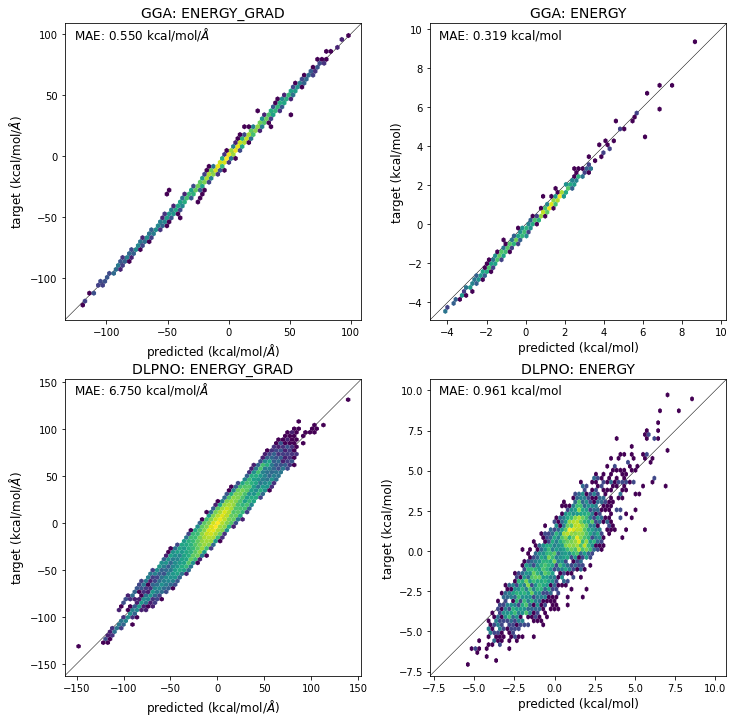

In [14]:
fig, ax_fig = plt.subplots(2, 2, figsize=(12, 12))

for ax_row, (method_key, method_loader) in zip(ax_fig, split_loaders.items()):
    
    results, targets, val_loss = evaluate(T.get_best_model(), method_loader['test'], loss_fn, device=DEVICE)
    
    for ax, key in zip(ax_row, units.keys()):
        pred_op = torch.cat
        targ_op = torch.cat
        
        if all([len(i.shape) == 0 for i in results[key]]):
            pred_op = torch.stack
        if all([len(i.shape) == 0 for i in targets[key]]):
            targ_op = torch.stack
        
            
        pred = pred_op(results[key], dim=0).detach().cpu().numpy().reshape(-1)
        targ = targ_op(targets[key], dim=0).detach().cpu().numpy().reshape(-1)

        plot_hexbin(pred, targ, ax, key, scale='linear')

        ax.set_title('%s: %s' % (method[method_key], key.upper()), fontsize=14)

plt.show()

## Transfer learning

Now we just have to freeze its convolution layers and unfreeze the last layers. In our case, the readout layers are those which make the prediction possible.

In [15]:
model = T.get_best_model()
model = freeze_parameters(model)
unfreeze_readout(model)

In [16]:
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=3e-4)

Retraining the model for a couple more epochs to use the transfer learning strategy:

In [17]:
T_transf = Trainer(
    model_path=OUTDIR_2,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=split_loaders['transf']['train'],
    validation_loader=split_loaders['transf']['val'],
    checkpoint_interval=1,
    hooks=train_hooks
)

In [18]:
T_transf.train(device=DEVICE, n_epochs=15)

 Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy | MAE_energy_grad | 


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3/4 [00:00<00:00, 33.19it/s]


26:14 |     1 |     3.000e-04 |    51.9680 |         29.6494 |     1.0186 |          4.4705 | 


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3/4 [00:00<00:00, 32.94it/s]


26:14 |     2 |     3.000e-04 |    21.6094 |         10.4264 |     1.9414 |          2.5279 | 


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3/4 [00:00<00:00, 33.02it/s]


26:14 |     3 |     3.000e-04 |     7.4214 |          4.2428 |     3.0166 |          1.5783 | 


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3/4 [00:00<00:00, 33.35it/s]


26:14 |     4 |     3.000e-04 |     4.0520 |          4.4448 |     3.5693 |          1.6294 | 


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3/4 [00:00<00:00, 33.29it/s]


26:15 |     5 |     3.000e-04 |     4.7771 |          5.3170 |     3.1866 |          1.7920 | 


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3/4 [00:00<00:00, 25.40it/s]


26:15 |     6 |     3.000e-04 |     5.1657 |          4.8970 |     2.0349 |          1.7049 | 


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3/4 [00:00<00:00, 33.44it/s]


26:15 |     7 |     3.000e-04 |     4.3470 |          3.6635 |     0.6517 |          1.4742 | 


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3/4 [00:00<00:00, 33.39it/s]


26:15 |     8 |     3.000e-04 |     3.1185 |          2.6120 |     0.5180 |          1.2162 | 


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3/4 [00:00<00:00, 33.13it/s]


26:16 |     9 |     3.000e-04 |     2.3270 |          2.2071 |     1.0409 |          1.0742 | 


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3/4 [00:00<00:00, 33.35it/s]


26:16 |    10 |     3.000e-04 |     2.1312 |          2.1925 |     0.7518 |          1.0656 | 


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3/4 [00:00<00:00, 29.11it/s]


26:16 |    11 |     3.000e-04 |     2.1406 |          2.1405 |     0.2035 |          1.0713 | 


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3/4 [00:00<00:00, 29.27it/s]


26:17 |    12 |     3.000e-04 |     2.0361 |          1.9539 |     0.9782 |          1.0169 | 


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3/4 [00:00<00:00, 29.37it/s]


26:17 |    13 |     3.000e-04 |     1.8386 |          1.7748 |     1.4043 |          0.9507 | 


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3/4 [00:00<00:00, 28.35it/s]


26:17 |    14 |     3.000e-04 |     1.6886 |          1.6835 |     1.2240 |          0.9195 | 


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3/4 [00:00<00:00, 29.99it/s]


26:17 |    15 |     3.000e-04 |     1.6101 |          1.6307 |     0.5772 |          0.9104 | 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 70.75it/s]


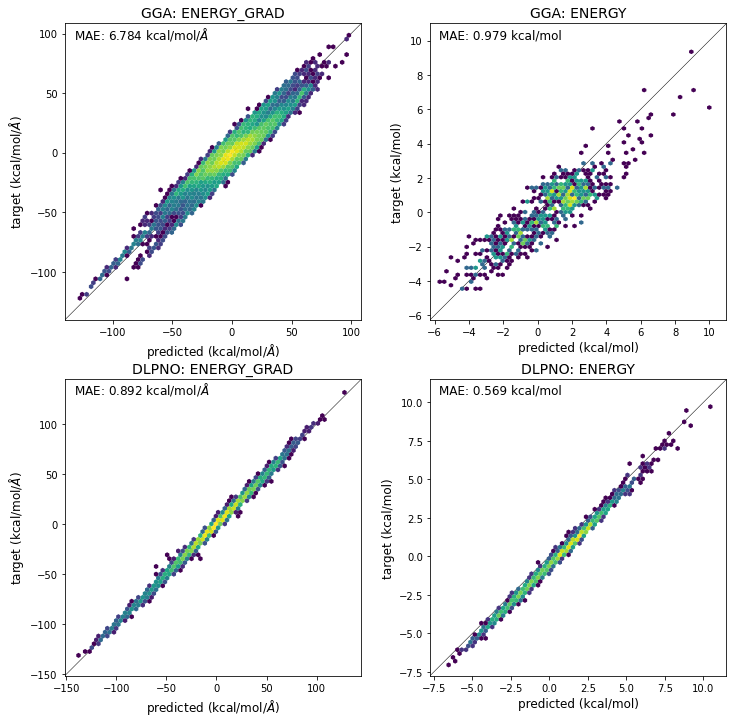

In [19]:
fig, ax_fig = plt.subplots(2, 2, figsize=(12, 12))

for ax_row, (method_key, method_loader) in zip(ax_fig, split_loaders.items()):
    
    results, targets, val_loss = evaluate(T_transf.get_best_model(), method_loader['test'], loss_fn, device=DEVICE)
    
    for ax, key in zip(ax_row, units.keys()):
        
        pred_op = torch.cat
        targ_op = torch.cat
        
        if all([len(i.shape) == 0 for i in results[key]]):
            pred_op = torch.stack
        if all([len(i.shape) == 0 for i in targets[key]]):
            targ_op = torch.stack
            
        pred = pred_op(results[key], dim=0).detach().cpu().numpy().reshape(-1)
        targ = targ_op(targets[key], dim=0).detach().cpu().numpy().reshape(-1)

        plot_hexbin(pred, targ, ax, key, scale='linear')

        ax.set_title('%s: %s' % (method[method_key], key.upper()), fontsize=14)

plt.show()